In [45]:
from primes.ulam_spiral import fill_primes
from primes.viz import display_primes, show_with_diagonals, build_ulam_spiral_ui, create_zero_matrix
from primes.goodness import detect_diagonal_segments, ulam_goodness
from ipywidgets import Output
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

import numpy as np

In [36]:
build_ulam_spiral_ui()

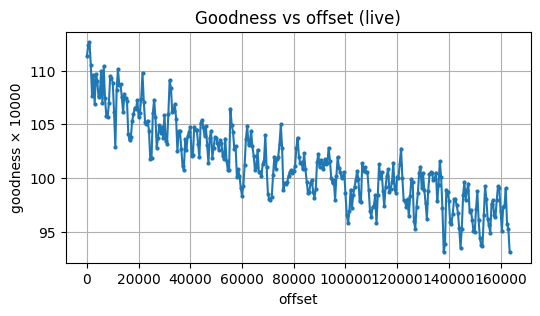

163500


KeyboardInterrupt: 

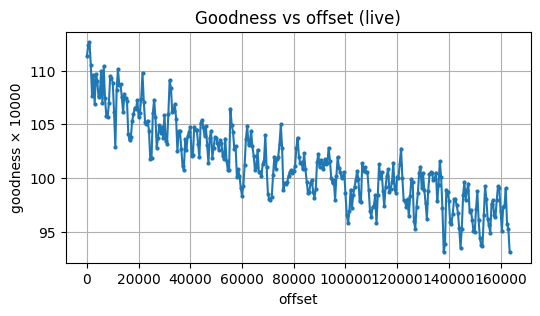

In [51]:
limit = 1000000
gap_tolerance = 0
min_run = 3
jumps = 500
matrix = create_zero_matrix(limit, padding=10)
size = int(round(limit ** 0.5))
filled_matrix = create_zero_matrix(limit, padding=10)
max_goodness = -1
offsets = []
scores = []

fig, ax = plt.subplots(figsize=(6, 3))
for j in range (1000):
    m = np.zeros((size, size), dtype=int)
    filled_matrix = fill_primes(m, j*jumps)
    goodness = ulam_goodness(filled_matrix, gap_tolerance,min_run)*10000
    offsets.append(j*jumps)
    scores.append(goodness)
    if goodness > max_goodness:
        max_goodness=goodness
        max_offset = j*jumps
    if (j*jumps) % 20 == 0:
        clear_output(wait=True)
        ax.clear()
        ax.plot(offsets, scores, marker="o", markersize=2, linestyle="-")
        ax.set_xlabel("offset")
        ax.set_ylabel("goodness × 10000")
        ax.set_title("Goodness vs offset (live)")
        ax.grid(True)

        display(fig)
        print(f"{j*jumps}")
print("Run Complete")
print(f"Max goodness: {max_goodness:.2f} at matrix({limit}), gap tolerance({gap_tolerance}), min run({min_run}), offset {max_offset}")